<a href="https://colab.research.google.com/github/guimarczewski/From-Data-to-Insights-with-Google-Cloud/blob/main/1_Exploring_%E2%80%8Band_%E2%80%8BPreparing_%E2%80%8Byour_%E2%80%8BData_with_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploring ​and ​Preparing ​your ​Data with BigQuery

O BigQuery é o banco de dados analítico de baixo custo, NoOps e totalmente gerenciado do Google. Com o BigQuery você pode consultar terabytes e terabytes de dados sem ter nenhuma infraestrutura para gerenciar ou precisar de um administrador de banco de dados. O BigQuery usa SQL e pode aproveitar o modelo de pagamento conforme o uso. O BigQuery permite que você se concentre na análise de dados para encontrar insights significativos.

Temos um conjunto de dados de comércio eletrônico recém-disponível que tem milhões de registros do Google Analytics para a Google Merchandise Store carregados em uma tabela no BigQuery. Neste laboratório, você usará uma cópia desse conjunto de dados. Cenários de exemplo são fornecidos, a partir dos quais você observa os dados e as formas de remover informações duplicadas. O laboratório, em seguida, orienta você através de uma análise mais aprofundada dos dados.

Para seguir e experimentar as consultas do BigQuery fornecidas para analisar os dados, consulte Sintaxe de [consulta SQL padrão](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax) .

Neste laboratório, iremos usar o BigQuery para:

* Acesse um conjunto de dados de comércio eletrônico

* Observe os metadados do conjunto de dados

* Remover entradas duplicadas

* Escrever e executar consultas

Identificar linhas duplicadas
Ver uma quantidade de dados de amostra pode fornecer uma maior intuição sobre o que está incluído no conjunto de dados. Para visualizar linhas de amostra da tabela sem usar SQL, clique na guia Visualizar .

Digitalize e percorra as linhas. Não há um campo singular que identifique exclusivamente uma linha, portanto, você precisa de lógica avançada para identificar linhas duplicadas.

Sua consulta usa a função SQL GROUP BYem todos os campos e conta ( COUNT) onde há linhas com os mesmos valores em todos os campos.

Se cada campo for único, o COUNTretornará 1, pois não há outros agrupamentos de linhas com o mesmo valor exato para todos os campos.

Se houver uma linha com os mesmos valores para todos os campos, eles serão agrupados e o COUNTserá maior que 1. A última parte da consulta é um filtro de agregação usando HAVING para mostrar apenas os resultados que tiverem um COUNTde duplicatas maior que 1.

In [ ]:
import pandas as pd
df = pd.read_csv('/content/data-to-insights.ecommerce.all_sessions_raw.csv', sep=",")

In [ ]:
df.head(5)

,fullVisitorId,channelGrouping,time,country,city,totalTransactionRevenue,transactions,timeOnSite,pageviews,sessionQualityDim,...,itemQuantity,itemRevenue,transactionRevenue,transactionId,pageTitle,searchKeyword,pagePathLevel1,eCommerceAction_type,eCommerceAction_step,eCommerceAction_option
0,9057380134604162825,Organic Search,0,Chile,Santiago,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,YouTube | Shop by Brand | Google Merchandise S...,NaN,/google+redesign/,0,1,NaN
1,6733216277509195585,Organic Search,30439,Canada,Montreal,NaN,NaN,92.0,6,NaN,...,NaN,NaN,NaN,NaN,Apparel,NaN,/google+redesign/,0,1,NaN
2,3816284800959944095,Organic Search,0,United States,San Francisco,NaN,NaN,NaN,1,NaN,...,NaN,NaN,NaN,NaN,Electronics,NaN,/google+redesign/,0,1,NaN
3,5303241840855387351,Referral,111316,United States,not available in demo dataset,NaN,NaN,171.0,7,NaN,...,NaN,NaN,NaN,NaN,Men's,NaN,/google+redesign/,0,1,NaN
4,9367099073822762422,Organic Search,33760,United States,Mountain View,NaN,NaN,104.0,8,NaN,...,NaN,NaN,NaN,NaN,Men's T-Shirts | Apparel | Google Merchandise ...,NaN,/google+redesign/,0,1,NaN


Schema: Nome do campo, Tipo, Modo e Descrição; as restrições lógicas usadas para organizar os dados

Details: metadados da tabela

Preview: visualização da tabela

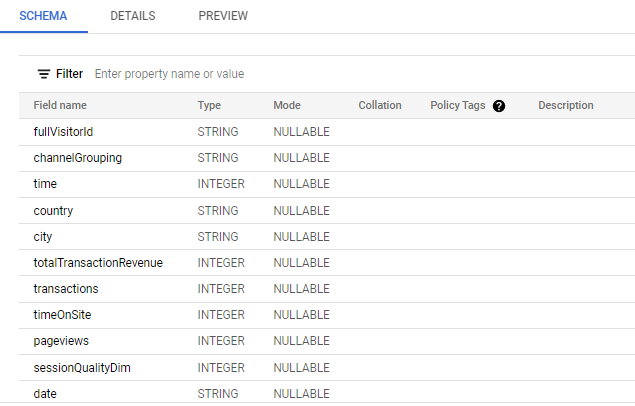

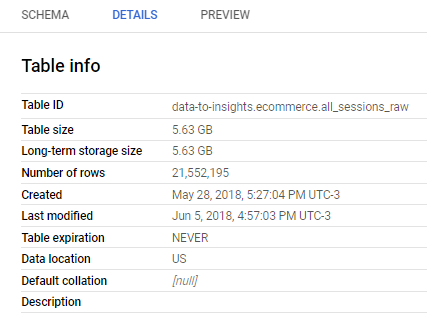

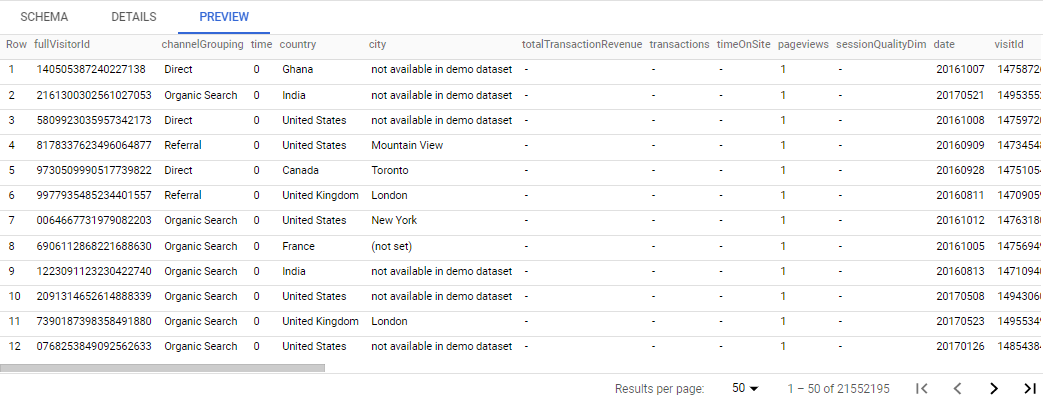

In [ ]:
#identificando dados duplicados
%%sql
SELECT 
  COUNT(*) as num_duplicate_rows, 
  * 
FROM
  `data-to-insights.ecommerce.all_sessions_raw`
GROUP BY
  fullVisitorId, channelGrouping, time, country, city, totalTransactionRevenue, transactions, timeOnSite, pageviews, sessionQualityDim, date, visitId, type, productRefundAmount, productQuantity, productPrice, productRevenue, productSKU, v2ProductName, v2ProductCategory, productVariant, currencyCode, itemQuantity, itemRevenue, transactionRevenue, transactionId, pageTitle, searchKeyword, pagePathLevel1, eCommerceAction_type, eCommerceAction_step, eCommerceAction_option
HAVING 
  num_duplicate_rows > 1;

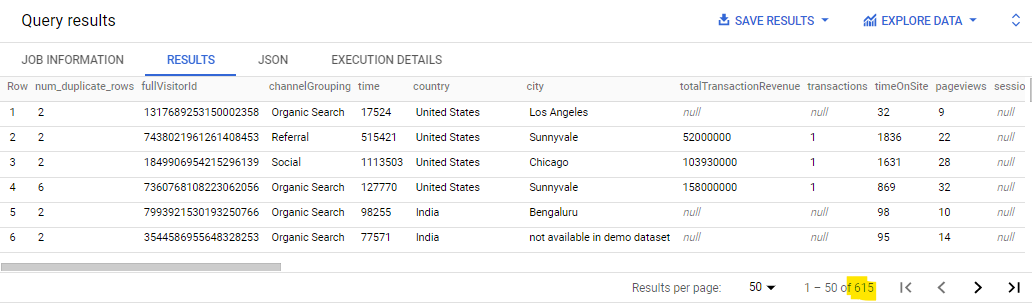

Analise a nova all_sessionstabela
Nesta seção, você usa uma tabela deduplicada chamada all_sessions.

Cenário: sua equipe de analistas de dados forneceu essa consulta e seus especialistas em esquema identificaram os campos-chave que devem ser exclusivos para cada registro de acordo com seu esquema .

Execute a consulta para confirmar que não existem duplicatas, desta vez na all_sessionstabela:



In [ ]:
%%sql
#standardSQL
# schema: https://support.google.com/analytics/answer/3437719?hl=en
SELECT
  fullVisitorId, # the unique visitor ID
  visitId, # a visitor can have multiple visits
  date, # session date stored as string YYYYMMDD
  time, # time of the individual site hit  (can be 0 to many per visitor session)
  v2ProductName, # not unique since a product can have variants like Color
  productSKU, # unique for each product
  type, # a visitor can visit Pages and/or can trigger Events (even at the same time)
  eCommerceAction_type, # maps to ‘add to cart', ‘completed checkout'
  eCommerceAction_step,
  eCommerceAction_option,
    transactionRevenue, # revenue of the order
    transactionId, # unique identifier for revenue bearing transaction
  COUNT(*) as row_count
FROM
  `data-to-insights.ecommerce.all_sessions`
GROUP BY 
  1,2,3 ,4, 5, 6, 7, 8, 9, 10,11,12
HAVING 
  row_count > 1 # find duplicates

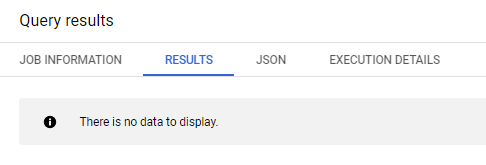

Escreva uma consulta que mostre o total de visitantes únicos
Sua consulta determina o total de visualizações contando product_viewse o número de visitantes únicos contando fullVisitorID.

Clique em COMPOR NOVA CONSULTA .

Escreva esta consulta no editor:

In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(DISTINCT fullVisitorId) AS unique_visitors
FROM `data-to-insights.ecommerce.all_sessions`;

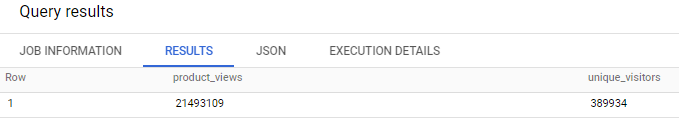

Agora escreva uma consulta que mostre o total de visitantes únicos ( fullVisitorID) pelo site de referência ( channelGrouping):

In [ ]:
%%sql
#standardSQL 
SELECT 
  COUNT(DISTINCT fullVisitorId) AS unique_visitors, 
  channelGrouping 
FROM `data-to-insights.ecommerce.all_sessions` 
GROUP BY channelGrouping 
ORDER BY channelGrouping DESC;

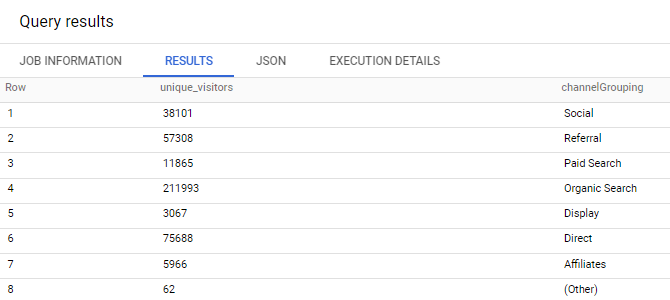

Escreva uma consulta para listar todos os nomes de produtos exclusivos ( v2ProductName) em ordem alfabética:



In [ ]:
%%sql
#standardSQL
SELECT
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
GROUP BY ProductName
ORDER BY ProductName

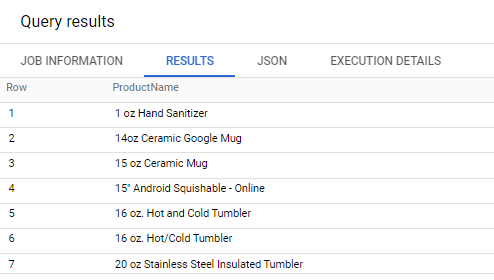

Escreva uma consulta para listar os cinco produtos com mais visualizações ( product_views) de todos os visitantes (inclua pessoas que visualizaram o mesmo produto mais de uma vez). Sua consulta conta o número de vezes que um produto ( v2ProductName) foi visualizado ( product_views), coloca a lista em ordem decrescente e lista as 5 principais entradas:

Dica: no Google Analytics, um visitante pode "visualizar" um produto durante os seguintes tipos de interação: 'página', 'exibição de tela', 'evento', 'transação', 'item', 'social', 'exceção', 'tempo '. Para nossos propósitos, basta filtrar apenas por tipo = 'PÁGINA'.



In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(*) AS product_views,
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

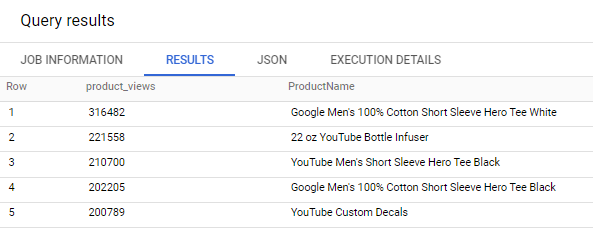

Bônus: agora refine a consulta para não mais contar duas visualizações de produtos para visitantes que visualizaram um produto muitas vezes. Cada visualização de produto distinta deve contar apenas uma vez por visitante.



In [ ]:
%%sql
WITH unique_product_views_by_person AS (
-- find each unique product viewed by each visitor
SELECT
 fullVisitorId,
 (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY fullVisitorId, v2ProductName )
-- aggregate the top viewed products and sort them
SELECT
  COUNT(*) AS unique_view_count,
  ProductName
FROM unique_product_views_by_person
GROUP BY ProductName
ORDER BY unique_view_count DESC
LIMIT 5

Dica: Você pode usar a WITHcláusula SQL para ajudar a dividir uma consulta complexa em várias etapas. Aqui, primeiro criamos uma consulta que encontra cada produto exclusivo por visitante e os conta uma vez. Em seguida, a segunda consulta realiza a agregação em todos os visitantes e produtos.



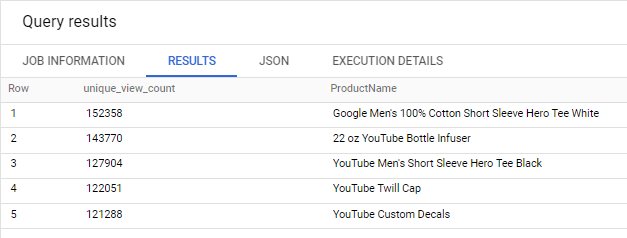

Em seguida, expanda sua consulta anterior para incluir o número total de produtos distintos encomendados e o número total de unidades encomendadas ( productQuantity):



In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(productQuantity) AS orders,
  SUM(productQuantity) AS quantity_product_ordered,
  v2ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

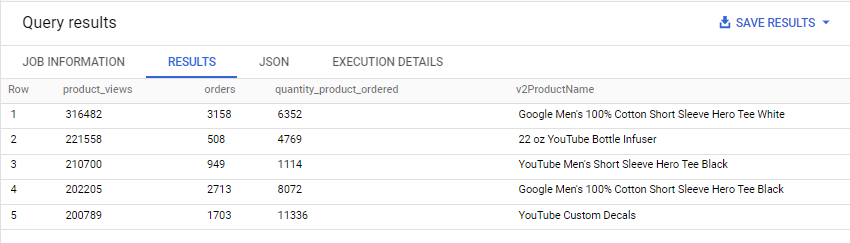

Expanda a consulta para incluir a quantidade média de produto por pedido (número total de unidades encomendadas/número total de pedidos ou SUM(productQuantity)/ COUNT(productQuantity)).



In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(productQuantity) AS orders,
  SUM(productQuantity) AS quantity_product_ordered,
  SUM(productQuantity) / COUNT(productQuantity) AS avg_per_order,
  (v2ProductName) AS ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE type = 'PAGE'
GROUP BY v2ProductName
ORDER BY product_views DESC
LIMIT 5;

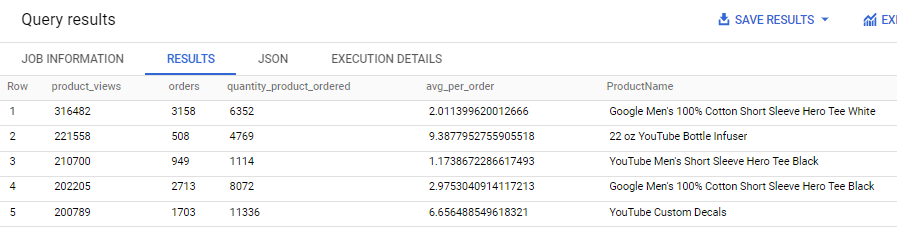

Desafio 1: Calcule uma taxa de conversão

Escreva uma consulta de taxa de conversão para produtos com estas qualidades:

Mais de 1000 unidades foram adicionadas a um carrinho ou encomendadas
e não são frisbees

-------
Responda estas perguntas:

Quantas vezes distintas o produto fez parte de um pedido (completo ou incompleto)?

Quantas unidades totais do produto faziam parte dos pedidos (completos ou incompletos)?

Qual produto teve a maior taxa de conversão?


In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(*) AS product_views,
  COUNT(productQuantity) AS potential_orders,
  SUM(productQuantity) AS quantity_product_added,
  (COUNT(productQuantity) / COUNT(*)) AS conversion_rate,
  v2ProductName
FROM `data-to-insights.ecommerce.all_sessions`
WHERE LOWER(v2ProductName) NOT LIKE '%frisbee%'
GROUP BY v2ProductName
HAVING quantity_product_added > 1000
ORDER BY conversion_rate DESC
LIMIT 10;

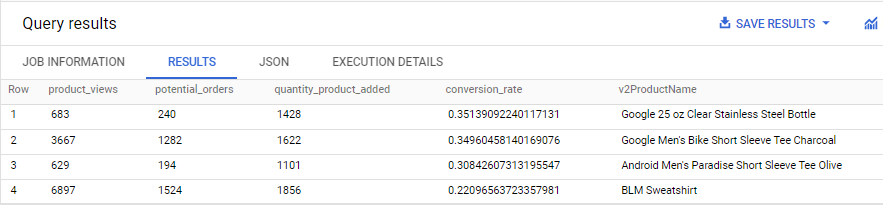

Desafio 2: acompanhar o progresso do checkout do visitante

Escreva uma consulta que mostre a eCommerceAction_typecontagem distinta de fullVisitorIdassociados a cada tipo.



In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(DISTINCT fullVisitorId) AS number_of_unique_visitors,
  eCommerceAction_type
FROM `data-to-insights.ecommerce.all_sessions`
GROUP BY eCommerceAction_type
ORDER BY eCommerceAction_type;

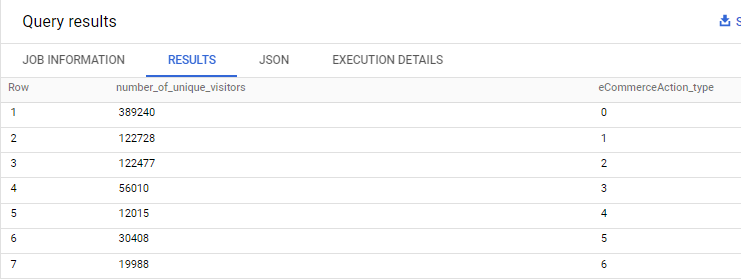

Bônus: Você recebe este mapeamento para o tipo de ação: 

Desconhecido = 0 

Clique nas listas de produtos = 1 

Visualizações de detalhes do produto = 2 

Adicionar produto(s) ao carrinho = 3 

Remover produto(s) do carrinho = 4 

Check-out = 5 

Concluído compra = 6 

Devolução da compra = 7 

Opções de checkout = 8

Use uma declaração de caso para adicionar uma nova coluna à sua consulta anterior para exibir o rótulo eCommerceAction_type (como "Compra concluída").



In [ ]:
%%sql
#standardSQL
SELECT
  COUNT(DISTINCT fullVisitorId) AS number_of_unique_visitors,
  eCommerceAction_type,
  CASE eCommerceAction_type
  WHEN '0' THEN 'Unknown'
  WHEN '1' THEN 'Click through of product lists'
  WHEN '2' THEN 'Product detail views'
  WHEN '3' THEN 'Add product(s) to cart'
  WHEN '4' THEN 'Remove product(s) from cart'
  WHEN '5' THEN 'Check out'
  WHEN '6' THEN 'Completed purchase'
  WHEN '7' THEN 'Refund of purchase'
  WHEN '8' THEN 'Checkout options'
  ELSE 'ERROR'
  END AS eCommerceAction_type_label
FROM `data-to-insights.ecommerce.all_sessions`
GROUP BY eCommerceAction_type
ORDER BY eCommerceAction_type;

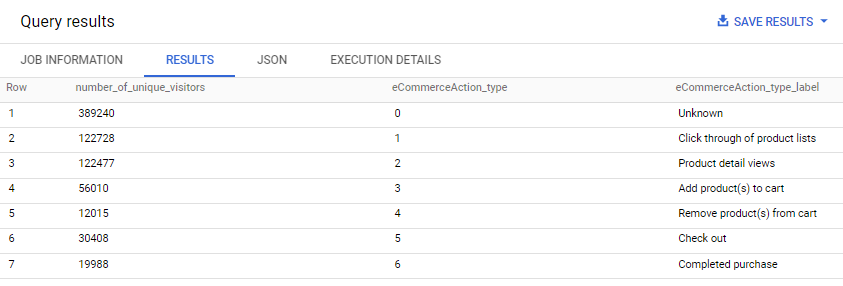

Qual é a porcentagem de visitantes que adicionaram algo ao carrinho e concluíram uma compra?

Resposta: 19988/56010 = 0,3568 ou 35,68%



Desafio 3: Rastrear carrinhos abandonados de sessões de alta qualidade

Escreva uma consulta usando funções de agregação que retornem os IDs de sessão exclusivos dos visitantes que adicionaram um produto ao carrinho, mas nunca concluíram o checkout (abandonaram o carrinho de compras).



In [ ]:
%%sql
#standardSQL
# high quality abandoned carts
SELECT  
  #unique_session_id
  CONCAT(fullVisitorId,CAST(visitId AS STRING)) AS unique_session_id,
  sessionQualityDim,
  SUM(productRevenue) AS transaction_revenue,
  MAX(eCommerceAction_type) AS checkout_progress
FROM `data-to-insights.ecommerce.all_sessions`
WHERE sessionQualityDim > 60 # high quality session
GROUP BY unique_session_id, sessionQualityDim
HAVING
  checkout_progress = '3' # 3 = added to cart
  AND (transaction_revenue = 0 OR transaction_revenue IS NULL)

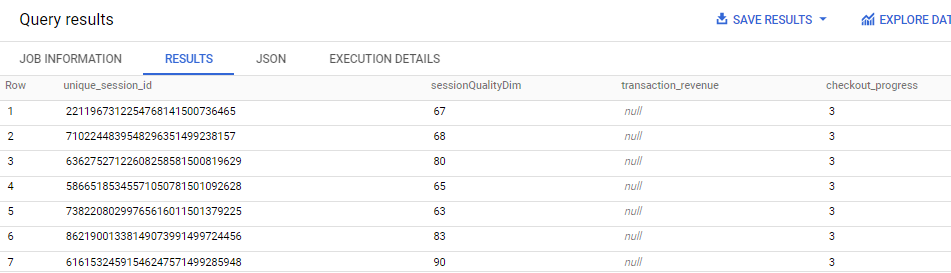